# Explore potential SNIa detected at early times

**NOTE:** Parts of this notebook cannot be run without access to the NERSC databases.
Contact Melissa Graham or Rob Knop for access to the unreleased photometry
from the individual difference images.
Only the combined, nightly-epoch photometry has been published so far.

## Set up and read in data

In [1]:
import psycopg2
import psycopg2.extras
import getpass
import pandas

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from astropy.time import Time

from copy import deepcopy
import time

First, the individual object photometry.

In [2]:
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")
db = psycopg2.connect(f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'")
db.autocommit = True
cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

DB User:  decat_ro
DB Password:  ········


In [3]:
tag = "latest"
db.rollback()
q = ( "SELECT id, tag FROM versiontags WHERE tag=%(tag)s" )
cursor.execute( q, { "tag": tag } )
row = cursor.fetchone()
tagid = row['id']
print(tagid)

1


In [10]:
my_cands_list = np.asarray(['DC21bkrj', 'DC21cwtlp', 'DC21cwtvj', 'DC21cwxin',
                            'DC21cyddn', 'DC21dhgr', 'DC21dslz', 'DC21dsocp',
                            'DC21dtwb', 'DC21fber', 'DC22gtccc', 'DC22gwmgv',
                            'DC22hvtwp', 'DC22iykha'], dtype='str')
print(my_cands_list)
print(' ')
my_cands_list_str = "('DC21bkrj', 'DC21cwtlp', 'DC21cwtvj', 'DC21cwxin', "\
                    "'DC21cyddn', 'DC21dhgr', 'DC21dslz', 'DC21dsocp', "\
                    "'DC21dtwb', 'DC21fber', 'DC22gtccc', 'DC22gwmgv', "\
                    "'DC22hvtwp', 'DC22iykha')"
print(my_cands_list_str)

['DC21bkrj' 'DC21cwtlp' 'DC21cwtvj' 'DC21cwxin' 'DC21cyddn' 'DC21dhgr'
 'DC21dslz' 'DC21dsocp' 'DC21dtwb' 'DC21fber' 'DC22gtccc' 'DC22gwmgv'
 'DC22hvtwp' 'DC22iykha']
 
('DC21bkrj', 'DC21cwtlp', 'DC21cwtvj', 'DC21cwxin', 'DC21cyddn', 'DC21dhgr', 'DC21dslz', 'DC21dsocp', 'DC21dtwb', 'DC21fber', 'DC22gtccc', 'DC22gwmgv', 'DC22hvtwp', 'DC22iykha')


In [6]:
%%time
q = ("SELECT od.ra, od.dec, od.mag, od.magerr, rbs.rb, "
     "i.filter, i.meanmjd, o.candidate_id, e.proposalid "
     "FROM objectdatas AS od "
     "INNER JOIN objectdata_versiontag AS odvt "
     "ON od.id=odvt.objectdata_id AND odvt.versiontag_id=%(tagid)s "
     "INNER JOIN objects AS o ON od.object_id=o.id "
     "INNER JOIN images AS i ON o.image_id=i.id "
     "INNER JOIN objectrbs as rbs ON od.id=rbs.objectdata_id AND rbs.rbtype_id=2 "
     "INNER JOIN exposures AS e ON i.exposure_id=e.id "
     "WHERE o.candidate_id IN "+my_cands_list_str)
cursor.execute(q, {'tagid': tagid})
df = pandas.DataFrame(cursor.fetchall())
print(len(df))

1751
CPU times: user 17.7 ms, sys: 1.3 ms, total: 19 ms
Wall time: 22.6 s


In [7]:
obj_ra     = np.asarray(df[0], dtype='float')
obj_dec    = np.asarray(df[1], dtype='float')
obj_mag    = np.asarray(df[2], dtype='float')
obj_mage   = np.asarray(df[3], dtype='float')
obj_rb     = np.asarray(df[4], dtype='float')
obj_filt   = np.asarray(df[5], dtype='str')
obj_mjd    = np.asarray(df[6], dtype='float')
obj_candid = np.asarray(df[7], dtype='str')
obj_propid = np.asarray(df[8], dtype='str')
del df

Next, the nightly-epoch photometry.

In [8]:
fnm = '../all_nightly_epochs_files/candidate_lightcurves.dat'
candLC_field = np.loadtxt(fnm, dtype='str', usecols=(0))
candLC_candid = np.loadtxt(fnm, dtype='str', usecols=(1))
candLC_caldate = np.loadtxt(fnm, dtype='str', usecols=(2))
candLC_mjd = np.loadtxt(fnm, dtype='float', usecols=(3))
candLC_filter = np.loadtxt(fnm, dtype='str', usecols=(4))
candLC_Nobj = np.loadtxt(fnm, dtype='int', usecols=(5))
candLC_mag = np.loadtxt(fnm, dtype='float', usecols=(6))
candLC_mage = np.loadtxt(fnm, dtype='float', usecols=(7))
candLC_mrb = np.loadtxt(fnm, dtype='float', usecols=(8))
candLC_lef = np.loadtxt(fnm, dtype='float', usecols=(9))
del fnm

Set light curve plot parameters.

In [32]:
clr = ['darkgreen', 'firebrick', 'saddlebrown', 'limegreen', 'orange', 'lightcoral']

all_filters = ['g','r','i']
all_fcolors = ['green','red','blue']
all_fshapes = ['o','s','^']
all_fsizes  = [5, 5, 6]

## Plot individual exposure photometry on day of first detection

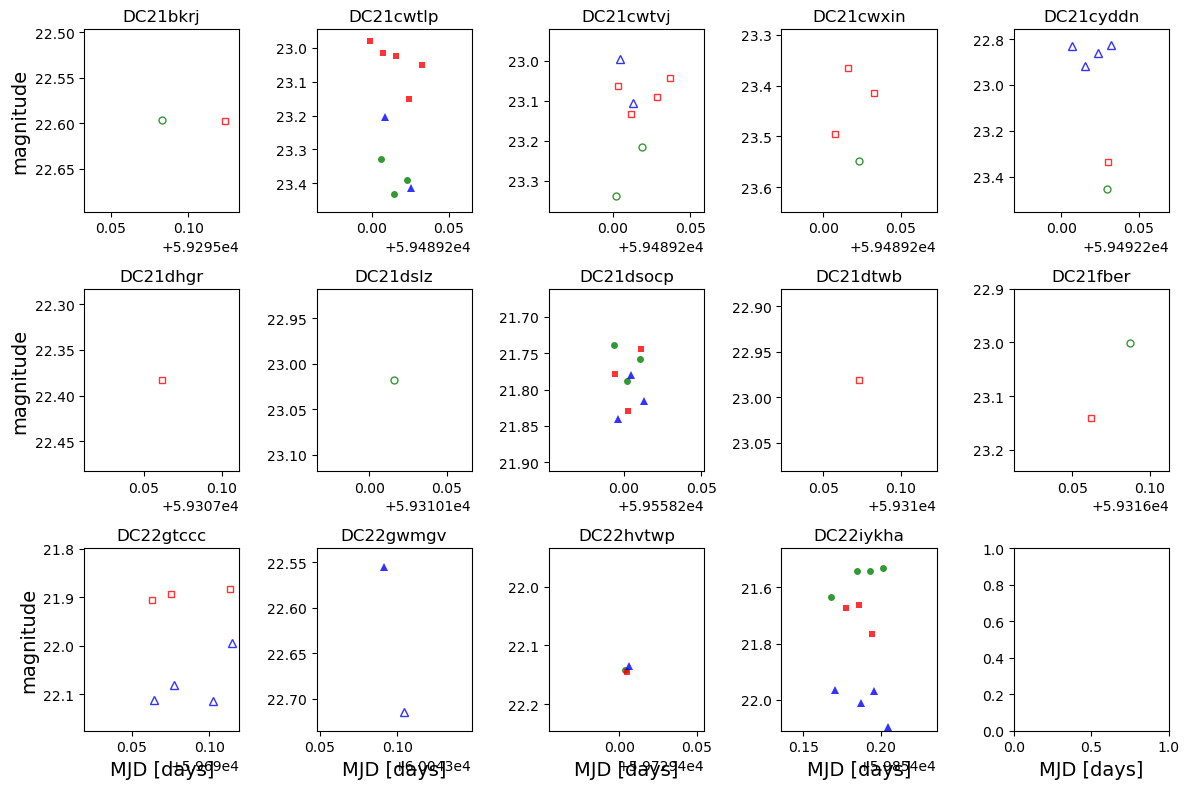

In [33]:
nrow = 3
ncol = 5
fig, ax = plt.subplots( nrow, ncol, figsize=(12, 8), sharex=False, sharey=False )

x = 0
for i in range(nrow):
    ax[i, 0].set_ylabel('magnitude', fontsize=14)
    for j in range(ncol):
        if x < len(my_cands_list):
            cand = my_cands_list[x]
            for f,filt in enumerate(all_filters):
                cx0 = np.where((candLC_candid == cand) & \
                               (candLC_filter == filt) & \
                               (candLC_mrb > 0.4))[0]
                cx1 = np.where((candLC_candid == cand) & \
                               (candLC_filter == filt) & \
                               (candLC_mrb <= 0.4) & \
                               (candLC_lef == 0))[0]
                cx2 = np.where((candLC_candid == cand) & \
                               (candLC_filter == filt) & \
                               (candLC_mrb <= 0.4) & \
                               (candLC_lef == 1))[0]
                # ax[i, j].plot(candLC_mjd[cx0], candLC_mag[cx0], 
                #              all_fshapes[f], ms=all_fsizes[f]+3, mew=0, alpha=0.4, color=all_fcolors[f], label=filt)
                # ax[i, j].plot(candLC_mjd[cx1], candLC_mag[cx1], 
                #              all_fshapes[f], ms=all_fsizes[f]+3, mew=1, alpha=0.4, color='none', mec=all_fcolors[f])
                # ax[i, j].plot(candLC_mjd[cx2], candLC_mag[cx2], 
                #              all_fshapes[f], ms=all_fsizes[f]+3, mew=0, alpha=0.2, color=all_fcolors[f])
                del cx0, cx1, cx2
                
                ox0 = np.where((obj_candid == cand) & (obj_filt == filt) & (obj_rb > 0.4))[0]
                ox1 = np.where((obj_candid == cand) & (obj_filt == filt) & (obj_rb <= 0.4))[0]
                ax[i, j].plot(obj_mjd[ox0], obj_mag[ox0], 
                             all_fshapes[f], ms=all_fsizes[f], mew=0, alpha=0.8, color=all_fcolors[f], label=filt)
                ax[i, j].plot(obj_mjd[ox1], obj_mag[ox1], 
                             all_fshapes[f], ms=all_fsizes[f], mew=1, alpha=0.8, color='none', mec=all_fcolors[f])

            cx = np.where((candLC_candid == cand) & (candLC_lef == 0))[0]
            xmin = np.min(candLC_mjd[cx])-0.05
            xmax = np.min(candLC_mjd[cx])+0.05
            del cx
            cx = np.where((candLC_candid == cand) & (candLC_lef == 0) 
                          & (candLC_mjd > xmin) & (candLC_mjd < xmax))[0]
            ymin = np.min(candLC_mag[cx])-0.1
            ymax = np.max(candLC_mag[cx])+0.1
            del cx        
            ax[i, j].set_ylim([ymax, ymin])
            ax[i, j].set_xlim([xmin, xmax])
            del xmin, xmax
            ax[i, j].set_title(cand)
            x += 1

# ax[0, 0].legend(loc='upper right', labelspacing=0.1, handletextpad=0.1, fontsize=14)

for j in range(ncol):
    ax[nrow-1, j].set_xlabel('MJD [days]', fontsize=14)

plt.tight_layout()
plt.show()
del x

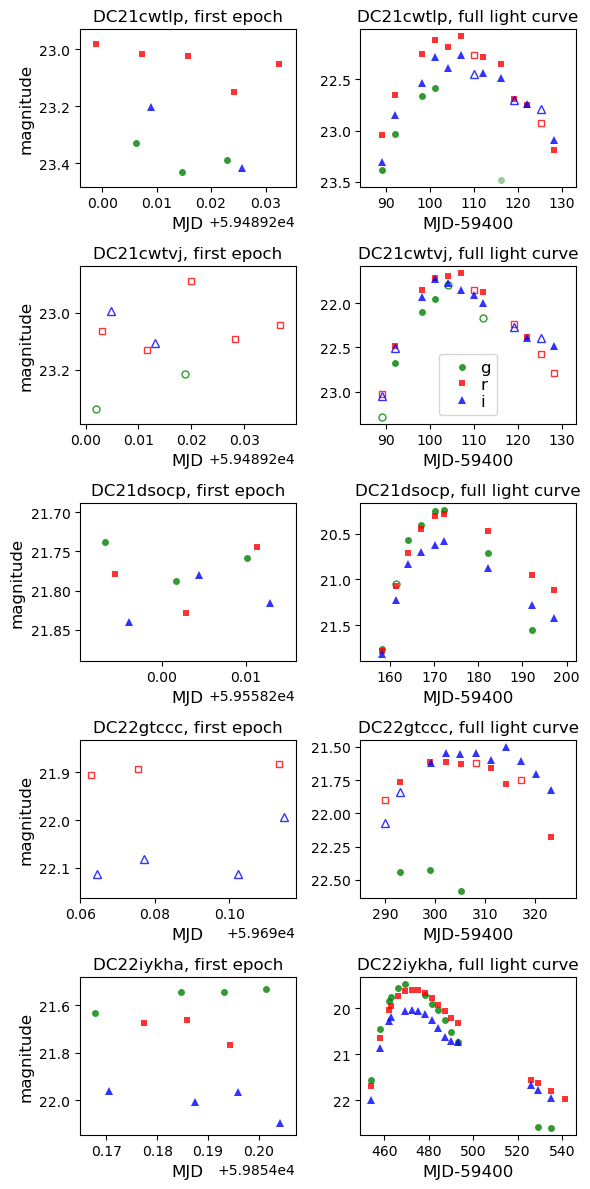

In [37]:
my_list = np.asarray(['DC21cwtlp','DC21cwtvj','DC21dsocp','DC22gtccc','DC22iykha'], dtype='str')

nrow = 5
fig, ax = plt.subplots(nrow, 2, figsize=(6, 12), sharex=False, sharey=False)

for i in range(nrow):
    cand = my_list[i]
    for f,filt in enumerate(all_filters):
        ox0 = np.where((obj_candid == cand) & (obj_filt == filt) & (obj_rb > 0.4))[0]
        ox1 = np.where((obj_candid == cand) & (obj_filt == filt) & (obj_rb <= 0.4))[0]
        ax[i, 0].plot(obj_mjd[ox0], obj_mag[ox0], 
                     all_fshapes[f], ms=all_fsizes[f], mew=0, alpha=0.8, color=all_fcolors[f], label=filt)
        ax[i, 0].plot(obj_mjd[ox1], obj_mag[ox1], 
                     all_fshapes[f], ms=all_fsizes[f], mew=1, alpha=0.8, color='none', mec=all_fcolors[f])

        cx0 = np.where((candLC_candid == cand) & \
                       (candLC_filter == filt) & \
                       (candLC_mrb > 0.4))[0]
        cx1 = np.where((candLC_candid == cand) & \
                       (candLC_filter == filt) & \
                       (candLC_mrb <= 0.4) & \
                       (candLC_lef == 0))[0]
        cx2 = np.where((candLC_candid == cand) & \
                       (candLC_filter == filt) & \
                       (candLC_mrb <= 0.4) & \
                       (candLC_lef == 1))[0]
        ax[i, 1].plot(candLC_mjd[cx0]-59400, candLC_mag[cx0], 
                     all_fshapes[f], ms=all_fsizes[f], mew=0, alpha=0.8, color=all_fcolors[f], label=filt)
        ax[i, 1].plot(candLC_mjd[cx1]-59400, candLC_mag[cx1], 
                     all_fshapes[f], ms=all_fsizes[f], mew=1, alpha=0.8, color='none', mec=all_fcolors[f])
        ax[i, 1].plot(candLC_mjd[cx2]-59400, candLC_mag[cx2], 
                     all_fshapes[f], ms=all_fsizes[f], mew=0, alpha=0.4, color=all_fcolors[f])
        del cx0, cx1, cx2

    cx = np.where((candLC_candid == cand) & (candLC_lef == 0))[0]
    xmin = np.min(candLC_mjd[cx])
    xmax = np.max(candLC_mjd[cx])
    ax[i, 1].invert_yaxis()
    ax[i, 1].set_xlim([xmin-59400-5, xmax-59400+5])
    ax[i, 1].set_xlabel('MJD-59400', fontsize=12)
    ax[i, 1].set_title(cand + ', full light curve')

    ax[i, 0].set_xlim([xmin-0.05, xmin+0.05])
    ox = np.where((obj_candid == cand) & (obj_mjd > xmin-0.05) & (obj_mjd < xmin+0.05))[0]
    xmin = np.min(obj_mjd[ox])-0.003
    xmax = np.max(obj_mjd[ox])+0.003
    ymin = np.min(obj_mag[ox])-0.05
    ymax = np.max(obj_mag[ox])+0.05
    ax[i, 0].set_xlim([xmin, xmax])
    ax[i, 0].set_ylim([ymax, ymin])
    ax[i, 0].set_xlabel('MJD', fontsize=12)
    ax[i, 0].set_ylabel('magnitude', fontsize=12)
    ax[i, 0].set_title(cand + ', first epoch')

    del cx, ox
    del xmin, xmax, ymin, ymax
    
ax[1, 1].legend(loc='best', labelspacing=0.1, handletextpad=0.1, fontsize=12)

plt.tight_layout()
plt.savefig('5_explore_potential_SNIa_early/plot1.png')
plt.show()